In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
cab_df = pd.read_csv(r'F:\Dataset\Datasets/cab_rides.csv')
weather_df = pd.read_csv(r'F:\Dataset\Datasets/weather.csv')

In [3]:
weather_df.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [4]:
cab_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [5]:
cab_df[cab_df['cab_type']=='Lyft']['surge_multiplier'].value_counts()

1.00    286433
1.25     11085
1.50      5065
1.75      2420
2.00      2239
2.50       154
3.00        12
Name: surge_multiplier, dtype: int64

In [6]:
weather_df = weather_df.fillna(0)

In [7]:
cab_df['date_time'] = pd.to_datetime(cab_df['time_stamp']/1000,unit='s')
weather_df['date_time'] = pd.to_datetime(cab_df['time_stamp']/1000,unit='s')

In [8]:
cab_df['merge_date'] = cab_df['source'].astype(str) + ' - ' + cab_df['date_time'].dt.date.astype(str) + ' - ' + cab_df['date_time'].dt.hour.astype(str)
weather_df['merge_date'] = weather_df['location'].astype(str) + ' - ' + weather_df['date_time'].dt.date.astype(str) + ' - ' + weather_df['date_time'].dt.hour.astype(str)
weather_df.index = weather_df['merge_date']
merged_df = cab_df.join(weather_df,on=['merge_date'],rsuffix='_w')

In [9]:
merged_df['day'] = merged_df['date_time'].dt.dayofweek
merged_df['hour'] = merged_df.date_time.dt.hour
del_cols = ['time_stamp','id','product_id','date_time','location','time_stamp_w','date_time_w','merge_date_w','merge_date','distance','price']
del_cols_df = merged_df.drop(del_cols,axis=1)

In [10]:
lyft_df = del_cols_df[del_cols_df['cab_type']=='Lyft']

In [11]:
lyft_df.shape

(625914, 13)

In [12]:
print(lyft_df['surge_multiplier'].unique())

[1.   1.25 2.5  2.   1.75 1.5  3.  ]


In [13]:

# Split the data
y = lyft_df['surge_multiplier'].copy()
X = lyft_df.drop('surge_multiplier',axis=1)


#convert y values to categorical values
from sklearn import preprocessing
lab = preprocessing.LabelEncoder()
y = lab.fit_transform(y)

In [14]:
print(X.shape)
print(y.shape)

(625914, 12)
(625914,)


In [15]:
# Running for smaller data
range_limit = 10000
X = X[:range_limit]
y = y[:range_limit]

print(X.shape)
print(y.shape)

(10000, 12)
(10000,)


In [16]:
categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)


numeric_pipeline = Pipeline(
    steps=[ ("impute", SimpleImputer(strategy="mean")), 
            ("scale", StandardScaler())]
)


cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

In [17]:
#Evaluating Different Model

In [18]:
def evaluateModel(model):
    # Bundle preprocessing and modeling code in a pipeline
    my_pipeline = imbpipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('smote',SMOTE(random_state=0, k_neighbors = 2)),
            ('model', model)]
    ) 
    scores = cross_val_score(my_pipeline, X, y,cv=4,scoring='accuracy')
    return scores

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
models = {}
models['XGB'] = XGBClassifier(random_state = 0)
models['RF'] = RandomForestClassifier(random_state=0, verbose= False)

model_scores = []
model_names = []

for model_name in models.keys():
  print("Working on ", model_name,".....")
  model_names.append(model_name)
  model_scores.append(evaluateModel(models[model_name]))

Working on  XGB .....
Working on  RF .....


In [20]:
for model_name, model_score in zip(model_names, model_scores):
   print(model_name, '\t: ',model_score.mean(), '\t ', model_score.std())

XGB 	:  0.9189999999999999 	  0.005758472019555192
RF 	:  0.9311 	  0.003525620512760837


[]

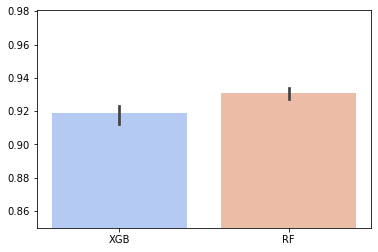

In [21]:
ax = sns.barplot(data=model_scores,palette="coolwarm")
ax.set_xticklabels(model_names)
plt.ylim(0.85)
plt.plot()